## Imports

In [1]:
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.neighbors import NearestNeighbors

## Init **Roads** DF

In [2]:
"""
Processes OpenStreetMap (OSM) road data from a CSV file and extracts individual road segments 
along with their geometric and identifying attributes.

Functionality:
- Reads a CSV file containing road data, including polyline coordinates for each road.
- Parses the polyline coordinates into individual line segments (start and end points).
- Computes midpoints and coefficients (A, B, G) for the standard form of each segment's line equation: Ax + By + G = 0.
- Stores these segment-level details in a new DataFrame for downstream analysis or processing.
- (Optional) Code sections for generating a GPX file are included but commented out.

Inputs:
- A CSV file specified by `filename_omp_streets`, containing at least the columns:
    - 'name': Name of the road
    - 'highway': Type of road (e.g., 'residential')
    - 'coordinates': A stringified list of dictionaries with 'lat' and 'lon' keys

Outputs:
- A new DataFrame `df_roads_segments` with one row per segment containing:
    - 'lat_start', 'lon_start': Starting point of the segment
    - 'lat_end', 'lon_end': Ending point of the segment
    - 'lat_mid', 'lon_mid': Midpoint of the segment
    - 'name', 'highway': Inherited from original road entry
    - 'original_row_id': Index of the original row in the input CSV
    - 'A_sl', 'B_sl', 'G_sl': Coefficients of the line equation for the segment

Note:
- Uses `ast.literal_eval` for safe parsing of the coordinates column.
- Some GPX writing functionality is present but commented out. To enable GPX export, uncomment the related sections.
"""


data = [
    ['11ου Συντάγματος', 'residential', '[{"lat": 37.5163202, "lon": 22.3670926}, {"lat": 37.5163008, "lon": 22.3671941}, {"lat": 37.5162872, "lon": 22.3672417}, {"lat": 37.5160483, "lon": 22.3678892}, {"lat": 37.5160213, "lon": 22.3679662}, {"lat": 37.5159004, "lon": 22.3683196}, {"lat": 37.5158288, "lon": 22.368505}, {"lat": 37.5157759, "lon": 22.3686216}, {"lat": 37.5157207, "lon": 22.3687294}, {"lat": 37.5156562, "lon": 22.3688413}, {"lat": 37.5155724, "lon": 22.3689578}, {"lat": 37.5154084, "lon": 22.3691304}]'],
    ['11ου Συντάγματος', 'residential', '[{"lat": 37.516339, "lon": 22.366991}, {"lat": 37.5163202, "lon": 22.3670926}]']
]
# Convert data to DataFrame
#df = pd.DataFrame(data, columns=["name", "highway", "coordinates"])

filename_omp_streets = "../../DataSets/API_Responses/OSM/OSM_roads.csv"

df_streets = pd.read_csv(filename_omp_streets, )

# List to store the new rows
new_rows = []

# for saving roads in gpx file ....
# f=open(f"./OSM_roads_tracks.gpx", "w")
# gpxtrackheader  = '<gpx xmlns="http://www.topografix.com/GPX/1/1" xmlns:gpxx="http://www.garmin.com/xmlschemas/GpxExtensions/v3" xmlns:wptx1="http://www.garmin.com/xmlschemas/WaypointExtension/v1" xmlns:gpxtpx="http://www.garmin.com/xmlschemas/TrackPointExtension/v1" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" creator="GPSMAP 62s" version="1.1" xsi:schemaLocation="http://www.topografix.com/GPX/1/1 http://www.topografix.com/GPX/1/1/gpx.xsd http://www.garmin.com/xmlschemas/GpxExtensions/v3 http://www8.garmin.com/xmlschemas/GpxExtensionsv3.xsd http://www.garmin.com/xmlschemas/WaypointExtension/v1 http://www8.garmin.com/xmlschemas/WaypointExtensionv1.xsd http://www.garmin.com/xmlschemas/TrackPointExtension/v1 http://www.garmin.com/xmlschemas/TrackPointExtensionv1.xsd">'+"\n"
# gpxtrackheader += '<metadata><link href="http://www.garmin.com">'
# gpxtrackheader += f'<text>OSM_roads_tracks</text>'
# gpxtrackheader += '</link><time>2025-02-01T18:01:37Z</time></metadata>'+"\n"
# gpxtrackheader += f'<trk><name>OSM_roads_tracks</name>'+"\n"
# gpxtrackheader += '<extensions><gpxx:TrackExtension><gpxx:DisplayColor>Cyan</gpxx:DisplayColor></gpxx:TrackExtension></extensions>'+"\n"
# #gpxtrackheader += '<trkseg>'+"\n"
# f.write(gpxtrackheader)
# aa=0


# Process each row in the DataFrame
for idx, row in df_streets.iterrows():
    # Parse the coordinates column
    coordinates = ast.literal_eval(row['coordinates'])  # Convert string of list to actual list of dicts
    
    # gpxtrackheader = '<trkseg>'+"\n"
    # f.write(gpxtrackheader)
       
    # Iterate over the consecutive coordinate pairs (lat-start, lon-start) and (lat-end, lon-end)
    for i in range(len(coordinates) - 1):

        # aa += 1

        start = coordinates[i]
        end = coordinates[i + 1]
        
        # Define the required values for the new DataFrame
        lat_start = start['lat']
        lon_start = start['lon']
        lat_end = end['lat']
        lon_end = end['lon']
        
        # Calculate the minimum latitude and midpoint longitude
        lat_mid = (lat_start + lat_end) / 2
        lon_mid = (lon_start + lon_end) / 2
        
        # straight line coefficients Ax + By + G = 0
        # considering as x == lat and  y == lon 
        # A = y2 - y1 so,
        A_sl = lon_end - lon_start
        # B = - (x2-x1) so,
        B_sl = -(lat_end - lat_start)
        # G = y1(x2-x1) -x1(y2-y1) 
        G_sl = lon_start*(lat_end-lat_start) + (-1)*lat_start*(lon_end-lon_start)  


        # gpxtrackpt = f'<trkpt lat="{lat_start}" lon="{lon_start}"><ele>{aa}</ele><time>2025-04-01T18:01:37Z</time></trkpt>'+"\n"
        # f.write(gpxtrackpt)
        
        # Append the new row with the calculated values and original information
        new_rows.append({
            'lat_start': lat_start,
            'lon_start': lon_start,
            'lat_end': lat_end,
            'lon_end': lon_end,
            'lat_mid': lat_mid,
            'lon_mid': lon_mid,
            'name': row['name'],
            'highway': row['highway'],
            'original_row_id': idx,   # The index can serve as the original row id
            'A_sl': A_sl,
            'B_sl': B_sl,
            'G_sl': G_sl
        })
    
    # gpxtrackheader = '</trkseg>'+"\n"
    # f.write(gpxtrackheader)

# gpxfooter = '</trk>'+"\n"
# f.write(gpxfooter)
# gpxfooter = '</gpx>'+"\n"
# f.write(gpxfooter)
# f.close()

# Create a new DataFrame from the list of new rows
df_roads_segments = pd.DataFrame(new_rows)

# Display the new DataFrame
print("dataframe df_roads_segments ...:")
print('   size is', df_roads_segments.size)


dataframe df_roads_segments ...:
   size is 412752


In [3]:
df2_streets = df_streets['highway'].unique()
print(df2_streets)


['residential' 'secondary' 'service' 'track' 'unclassified' 'footway'
 'tertiary' 'primary_link' 'raceway' 'pedestrian' 'motorway_link'
 'primary' 'steps' 'rest_area' 'living_street' 'tertiary_link'
 'secondary_link' 'motorway' 'path']


## Define **Haversine Disatnce**

In [4]:
def haversine_distance(x, y):
    """
    Calculates the great-circle distance(s) between two points on the Earth's surface 
    using the Haversine formula.

    Parameters:
    ----------
    x : np.ndarray
        A NumPy array of shape (2,) or (N, 2) containing latitude and longitude in degrees 
        for the starting point(s). Format: [lat, lon] or [[lat1, lon1], [lat2, lon2], ...].
    y : np.ndarray
        A NumPy array of the same shape as `x`, containing the destination point(s).

    Returns:
    -------
    float or np.ndarray
        The Haversine distance(s) in kilometers between each corresponding pair of coordinates.

    Notes:
    -----
    - The inputs are expected in degrees and converted internally to radians.
    - If 2D arrays are provided, distances are calculated element-wise across rows.
    - Earth's radius is approximated as 6371 km.
    
    Example:
    --------
    >>> start = np.array([37.5163202, 22.3670926])
    >>> end = np.array([37.5162872, 22.3672417])
    >>> distance = haversine_distance(start, end)
    >>> print(distance)
    0.014

    """

def haversine_distance(x, y): # x,y values or arrays== np.arrays
    # Convert degrees to radians
    x = np.radians(x)
    y = np.radians(y)
    # print('x radians',x,'y radians',y)
    # Compute differences in latitudes and longitudes
    dlat = y[0] - x[0]
    dlon = y[1] - x[1]
    
    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(x[0]) * np.cos(y[0]) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    # Radius of Earth in kilometers
    r = 6371
    
    return r * c


# Example usage
coords_start = np.array([[37.5163202, 22.3670926], [37.5163008, 22.3671941]])  # (lat, lon) for start
coords_end = np.array([[37.5162872, 22.3672417], [37.5160483, 22.3678892]])    # (lat, lon) for end

distances = haversine_distance(coords_start, coords_end)
print('distances',distances)


distances [0.02257018 0.0733741 ]


## Init **DataSets DF**

In [5]:
"""
Loads vehicle GPS data from a CSV file and prepares it for spatial processing.

Functionality:
-------------
- Reads a CSV file containing vehicle coordinate data (latitude and longitude).
- Constructs a new column `coordinates` in the form of a list of tuples: [(lat, lng)].
  This is useful for uniformity in later processing involving sequences of GPS points.

Inputs:
------
- filename_coords (str): Path to the CSV file containing at least 'lat' and 'lng' columns.

Output:
------
- df_coords (pd.DataFrame): A DataFrame with a new column `coordinates`, where each entry is a list 
  containing a single tuple (lat, lng).

Example Row After Processing:
----------------------------
| lat        | lng         | coordinates              |
|------------|-------------|--------------------------|
| 37.515432  | 22.368752   | [(37.515432, 22.368752)] |

Note:
-----
- The wrapping in a list [(lat, lng)] anticipates possible extension to multi-point trajectories.
"""

# Load vehicle data
filename_coords = "./all_vehicles_tripoli_data_processed.csv" #./all_vehicle_responses.csv

df_coords = pd.read_csv(filename_coords)

df_coords["coordinates"] = df_coords.apply(lambda row: [(row["lat"], row["lng"])], axis=1)

print("dataframe df_coords (vehicles coordinates), df_coords['coordinates']...:") 
print(df_coords["coordinates"])


dataframe df_coords (vehicles coordinates), df_coords['coordinates']...:
0          [(37.5108333, 22.38571)]
1        [(37.5106033, 22.3859766)]
2          [(37.51064, 22.3859266)]
3        [(37.5107499, 22.3859066)]
4        [(37.5108766, 22.3856983)]
                    ...            
25304      [(37.53146, 22.3697683)]
25305     [(37.531275, 22.3694733)]
25306    [(37.5311216, 22.3691949)]
25307    [(37.5311483, 22.3689666)]
25308    [(37.5312433, 22.3687049)]
Name: coordinates, Length: 25309, dtype: object


## **NearestNeighbors**

In [6]:
"""
Performs a nearest neighbor search to find the closest road segment midpoint 
to a given geographic query point using the Haversine distance metric.

Functionality:
-------------
- Extracts midpoint coordinates (`lat_mid`, `lon_mid`) from a DataFrame of road segments 
  and converts them to a NumPy array.
- Uses `NearestNeighbors` from scikit-learn with a BallTree index and a custom Haversine metric.
- Fits the model to the road segment midpoints.
- Queries the model with a specified point to find the closest midpoint in terms of geographic distance.

Inputs:
------
- `df_roads_segments`: A DataFrame containing at least 'lat_mid' and 'lon_mid' columns.
- `query_point` (np.ndarray): A 1D array representing a geographic location [lat, lon].

Outputs:
-------
- Prints the index of the closest road segment midpoint.
- Prints the corresponding midpoint coordinates from the dataset.
- Prints the Haversine distance (in kilometers) between the query point and the closest midpoint.

Notes:
-----
- The Haversine metric ensures that distances are computed on the Earth's curved surface.
- The `query_point` must be reshaped to 2D with `.reshape(1, -1)` to match input requirements of `kneighbors()`.
- Distance is returned in kilometers; you can multiply by 1,000 to convert to meters if needed.

Example:
-------
Querying the closest road segment midpoint to [37.51533, 22.38789].

"""

# ! print('Nearest Neighnoors example using roads_segments_coords[:10,:] : first 10 rows, all columns')
# ! print(roads_segments_coords[:10,:]) # first 10 rows, all columns -- np.array not dataframe

print('NearestNeighbors example using roads_segments_coords, all 10 rows, all columns')
roads_segments_coords = df_roads_segments[['lat_mid', 'lon_mid']].values #! 2D numpy array
# Create NearestNeighbors model with BallTree for indexing and custom metric
neighbors = NearestNeighbors(n_neighbors=1, metric=haversine_distance, algorithm='ball_tree')
# neighbors.fit(df_roads_segments[['lat_mid', 'lon_mid']].values)
# better use:
neighbors.fit(roads_segments_coords) # memorizes roads to find NearestNeighbors (builds the search tree)

# Example query point
query_point = np.array([37.5153299, 22.3878963])
# Find the closest point to the query point
# dist, ind = neighbors.kneighbors(query_point)
dist, ind = neighbors.kneighbors(query_point.reshape(1, -1))
# ind == indices of rows roads_segments_coords, dsit == haversine distanses between querypoint and neighbor
print('TEST, roads_segments_coords (first 10 rows, all columns), query_point=',query_point)
print(" => Closest point index:", ind)
#print("Distance (in meters) to closest point:", dist * 111,000) #! 1 degree (coordinate) == 11,000 meters
print(roads_segments_coords[ind, :])  #### [lat_mid,lot_mid]
# we found the closest line segment (mid point of it)



NearestNeighbors example using roads_segments_coords, all 10 rows, all columns
TEST, roads_segments_coords (first 10 rows, all columns), query_point= [37.5153299 22.3878963]
 => Closest point index: [[32311]]
[[[37.5149445 22.3877528]]]


## **Project Points to Segments**

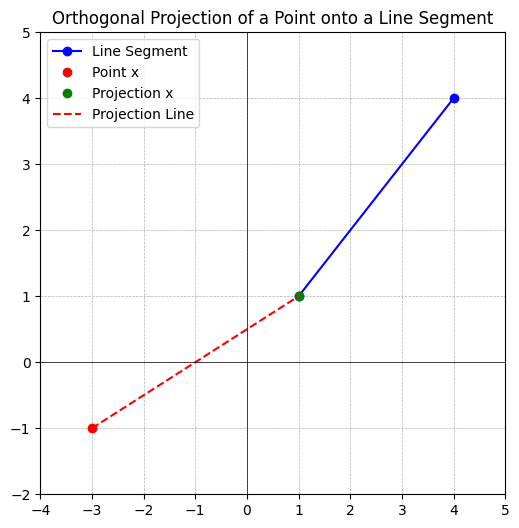

In [7]:
def orthogonal_projection(a, b, x):
    """
    Computes the orthogonal projection of a point `x` onto a line segment defined by endpoints `a` and `b`.

    Parameters:
    ----------
    a : array-like of shape (2,)
        The starting point of the line segment (e.g., [x1, y1]).
    b : array-like of shape (2,)
        The ending point of the line segment (e.g., [x2, y2]).
    x : array-like of shape (2,)
        The point to be projected onto the line segment.

    Returns:
    -------
    x_proj : np.ndarray of shape (2,)
        The coordinates of the projection of point `x` onto the segment [a, b]. If the orthogonal
        projection falls outside the segment, it is clamped to the nearest endpoint.

    Notes:
    -----
    - This function projects `x` onto the infinite line through `a` and `b`, and then clamps the result 
      to stay within the segment if necessary.
    - Useful in geometry tasks such as distance-to-segment calculations, map-matching, and path analysis.
    """
    a, b, x = map(np.asarray, (a, b, x))
    ab = b - a  # Direction of the segment
    ax = x - a  # Vector from a to x
 
    # Projection scalar (normalized dot product)
    t = np.dot(ax, ab) / np.dot(ab, ab)
 
    # Clamp t to ensure projection is within segment
    t = np.clip(t, 0, 1)
 
    # Compute the projected point
    x_proj = a + t * ab
    return x_proj
 
def plot_projection(a, b, x):
    """
    Visualizes the orthogonal projection of a point onto a line segment.

    Parameters:
    ----------
    a : array-like of shape (2,)
        The starting point of the line segment.
    b : array-like of shape (2,)
        The ending point of the line segment.
    x : array-like of shape (2,)
        The point to be projected onto the segment.

    Behavior:
    --------
    - Plots the segment [a, b] as a blue line.
    - Plots the point `x` in red and its orthogonal projection in green.
    - Draws a dashed red line from `x` to the projected point.
    - Displays axes, grid, and legend for context.

    Useful For:
    ----------
    - Verifying geometric computations visually.
    - Educational or debugging purposes when working with projections or map geometry.
    """
    x_proj = orthogonal_projection(a, b, x)
 
    plt.figure(figsize=(6, 6))
 
    # Plot line segment
    plt.plot([a[0], b[0]], [a[1], b[1]], 'bo-', label='Line Segment')
 
    # Plot original point
    plt.plot(x[0], x[1], 'ro', label='Point x')
 
    # Plot projected point
    plt.plot(x_proj[0], x_proj[1], 'go', label='Projection x')
    plt.plot([x[0], x_proj[0]], [x[1], x_proj[1]], 'r--', label='Projection Line')
 
    plt.xlim(min(a[0], b[0], x[0]) - 1, max(a[0], b[0], x[0]) + 1)
    plt.ylim(min(a[1], b[1], x[1]) - 1, max(a[1], b[1], x[1]) + 1)
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.legend()
    plt.title("Orthogonal Projection of a Point onto a Line Segment")
    plt.show()
 
# Example usage
a = np.array([1, 1])
b = np.array([4, 4])
x = np.array([-3, -1])  # Point to be projected
 
plot_projection(a, b, x)


In [8]:
def project_points_to_segments(px, py, x1, y1, x2, y2):
    """
    Projects a batch of 2D points onto corresponding line segments, clamping to the segment and
    preserving points that lie outside the vertical extent of the segment.

    Parameters
    ----------
    px : np.ndarray of shape (N,)
        X-coordinates of the input points to be projected.
    py : np.ndarray of shape (N,)
        Y-coordinates of the input points to be projected.
    x1 : np.ndarray of shape (N,)
        X-coordinates of the starting points of the segments.
    y1 : np.ndarray of shape (N,)
        Y-coordinates of the starting points of the segments.
    x2 : np.ndarray of shape (N,)
        X-coordinates of the ending points of the segments.
    y2 : np.ndarray of shape (N,)
        Y-coordinates of the ending points of the segments.

    Returns
    -------
    proj_x : np.ndarray of shape (N,)
        X-coordinates of the projected points on the segments.
    proj_y : np.ndarray of shape (N,)
        Y-coordinates of the projected points on the segments.

    Notes
    -----
    - The projection is orthogonal (perpendicular) to the line segment.
    - If a segment has zero length (i.e., start and end points are identical), the corresponding
      projected point defaults to the segment start.
    - If a point lies outside the vertical bounds (y-range) of its segment, the projection is discarded
      and the original point is returned unchanged.

    Example
    -------
    >>> px = np.array([3, 6, 2])
    >>> py = np.array([4, 5, 8])
    >>> x1 = np.array([1, 5, 0])
    >>> y1 = np.array([2, 4, 1])
    >>> x2 = np.array([5, 7, 3])
    >>> y2 = np.array([6, 5, 4])
    >>> proj_x, proj_y = project_points_to_segments(px, py, x1, y1, x2, y2)
    """

    # Compute segment vectors and point vectors
    vx = x2 - x1  # Segment direction x-component
    vy = y2 - y1  # Segment direction y-component
    wx = px - x1  # Vector from segment start to point x-component
    wy = py - y1  # Vector from segment start to point y-component

    # Compute dot products
    dot_vv = vx * vx + vy * vy  # Dot product of v with itself
    dot_wv = wx * vx + wy * vy  # Dot product of w with v

    # Avoid division by zero (if the segment is a single point)
    mask_zero_length = dot_vv == 0
    t = np.zeros_like(dot_wv, dtype=np.float64)  # Explicitly specify float type for 't'
    np.divide(dot_wv, dot_vv, out=t, where=~mask_zero_length)  # Perform division

    # Clamp t between 0 and 1 to stay within the segment
    t = np.clip(t, 0, 1)

    # Compute projected points
    proj_x = x1 + t * vx
    proj_y = y1 + t * vy

    # If a point is outside the vertical range of its segment, leave it unchanged
    mask_outside_vertical = (py < np.minimum(y1, y2)) | (py > np.maximum(y1, y2))
    proj_x = np.where(mask_outside_vertical, px, proj_x)
    proj_y = np.where(mask_outside_vertical, py, proj_y)

    return proj_x, proj_y

# Example Usage with Batched Inputs
px = np.array([3, 6, 2])  # Points to project
py = np.array([4, 5, 8])
x1 = np.array([1, 5, 0])  # Segment start points
y1 = np.array([2, 4, 1])
x2 = np.array([5, 7, 3])  # Segment end points
y2 = np.array([6, 5, 4])

px = np.array([37.5, 38.0, 37.8])  # Points to project
py = np.array([22.3, 22.5, 22.6])
x1 = np.array([37.516, 37.4, 37.7])  # Segment start points
y1 = np.array([22.367, 22.2, 22.5])
x2 = np.array([37.520, 37.6, 37.9])  # Segment end points
y2 = np.array([22.370, 22.4, 22.7]) 


proj_x, proj_y = project_points_to_segments(px, py, x1, y1, x2, y2)
print("Projected X:", proj_x)
print("Projected Y:", proj_y)

Projected X: [37.5 38.  37.8]
Projected Y: [22.3 22.5 22.6]


In [10]:
def latlon_to_cartesian(lat, lon):
    """
    Converts latitude and longitude coordinates to 3D Cartesian coordinates on a unit sphere.

    Parameters:
        lat (array-like): Latitudes in degrees.
        lon (array-like): Longitudes in degrees.

    Returns:
        np.ndarray: Cartesian coordinates of shape (..., 3).
    """
    
    lat, lon = np.radians(lat), np.radians(lon)
    x = np.cos(lat) * np.cos(lon)
    y = np.cos(lat) * np.sin(lon)
    z = np.sin(lat)
    return np.stack([x, y, z], axis=-1)  # Shape (N, 3)
def cartesian_to_latlon(cart):
    """
    Converts 3D Cartesian coordinates on a unit sphere back to latitude and longitude.

    Parameters:
        cart (np.ndarray): Cartesian coordinates of shape (..., 3).

    Returns:
        tuple: A tuple (lat, lon) of arrays in degrees.
    """
    
    x, y, z = cart[..., 0], cart[..., 1], cart[..., 2]
    lat = np.arcsin(z)  # Inverse sine for latitude
    lon = np.arctan2(y, x)  # Arctan2 for longitude
    return np.degrees(lat), np.degrees(lon)
    
def project_geodesic_points(px, py, x1, y1, x2, y2):
    """
    Projects points in lat/lon (px, py) onto geodesic segments defined by endpoints
    (x1, y1) to (x2, y2), on a spherical Earth model.

    The projection is computed on the unit sphere via vector algebra. If the orthogonal 
    projection of a point falls outside the arc defined by the endpoints, it is snapped 
    to the nearest endpoint.

    Parameters:
        px (np.ndarray): Latitudes of the points to be projected. Shape (N,).
        py (np.ndarray): Longitudes of the points to be projected. Shape (N,).
        x1 (np.ndarray): Latitudes of the segment start points. Shape (N,).
        y1 (np.ndarray): Longitudes of the segment start points. Shape (N,).
        x2 (np.ndarray): Latitudes of the segment end points. Shape (N,).
        y2 (np.ndarray): Longitudes of the segment end points. Shape (N,).

    Returns:
        tuple:
            proj_lat (np.ndarray): Projected latitudes. Shape (N,).
            proj_lon (np.ndarray): Projected longitudes. Shape (N,).
    """
    
    # Convert lat-lon to Cartesian 3D coordinates
    P = latlon_to_cartesian(px, py)  # Shape (N, 3)
    A = latlon_to_cartesian(x1, y1)
    B = latlon_to_cartesian(x2, y2)

    # Compute the great-circle normal (cross product of A and B)
    N = np.cross(A, B)  # Shape (N, 3)
    N /= np.linalg.norm(N, axis=-1, keepdims=True)  # Normalize

    # Compute projection of P onto the great-circle plane
    P_proj = P - np.sum(P * N, axis=-1, keepdims=True) * N
    P_proj /= np.linalg.norm(P_proj, axis=-1, keepdims=True)  # Normalize to stay on unit sphere

    # Convert projected Cartesian points back to lat-lon
    proj_lat, proj_lon = cartesian_to_latlon(P_proj)

    # Check if projected points are within segment bounds using angular distance
    dot_AB = np.sum(A * B, axis=-1)  # Cosine of angle between A and B
    dot_AP = np.sum(A * P_proj, axis=-1)  # Cosine of angle between A and projected point
    dot_BP = np.sum(B * P_proj, axis=-1)  # Cosine of angle between B and projected point

    # If the projection falls outside the segment, snap to the nearest endpoint
    mask_before_A = dot_AP < dot_AB  # If P_proj is before A
    mask_after_B = dot_BP < dot_AB   # If P_proj is after B

    proj_lat = np.where(mask_before_A, x1, proj_lat)
    proj_lon = np.where(mask_before_A, y1, proj_lon)
    proj_lat = np.where(mask_after_B, x2, proj_lat)
    proj_lon = np.where(mask_after_B, y2, proj_lon)

    return proj_lat, proj_lon



# Example Usage with Batched Inputs
px = np.array([37.5, 38.0, 37.8])  # Points to project
py = np.array([22.3, 22.5, 22.6])
x1 = np.array([37.516, 37.4, 37.7])  # Segment start points
y1 = np.array([22.367, 22.2, 22.5])
x2 = np.array([37.520, 37.6, 37.9])  # Segment end points
y2 = np.array([22.370, 22.4, 22.7])

proj_lat, proj_lon = project_geodesic_points(px, py, x1, y1, x2, y2)

print("Projected Latitudes:", proj_lat)
print("Projected Longitudes:", proj_lon)


Projected Latitudes: [37.52       37.6        37.80006828]
Projected Longitudes: [22.37       22.4        22.59989064]


In [11]:
filename_coords = "./all_vehicles_tripoli_data_processed.csv"   # "./all_vehicle_responses.csv"
df_coords = pd.read_csv(filename_coords)

df_coords["coordinates"] = df_coords.apply(lambda row: [(row["lat"], row["lng"])], axis=1)
print(df_coords["coordinates"])


0          [(37.5108333, 22.38571)]
1        [(37.5106033, 22.3859766)]
2          [(37.51064, 22.3859266)]
3        [(37.5107499, 22.3859066)]
4        [(37.5108766, 22.3856983)]
                    ...            
25304      [(37.53146, 22.3697683)]
25305     [(37.531275, 22.3694733)]
25306    [(37.5311216, 22.3691949)]
25307    [(37.5311483, 22.3689666)]
25308    [(37.5312433, 22.3687049)]
Name: coordinates, Length: 25309, dtype: object


## ** Calculate Projection into a new csv 

In [12]:
#from tqdm import tqdm

"""         
 # Append the new row with the calculated values and original information
        new_rows.append({
            'lat_start': lat_start,
            'lon_start': lon_start,
            'lat_end': lat_end,
            'lon_end': lon_end,
            'lat_mid': lat_mid,
            'lon_mid': lon_mid,
            'name': row['name'],
            'highway': row['highway'],
            'original_row_id': idx  # The index can serve as the original row id
        })

# Create a new DataFrame from the list of new rows
df_roads_segments = pd.DataFrame(new_rows)  
 """


projection_distance_threshold_meters = 5.0
df_coords['coords_projected']        = None
df_coords['is_projected']            = 0
df_coords['nearest_segment_start']            = None
df_coords['nearest_segment_end']            = None
df_coords['nearest_segment_index']            = None
num_points_projected                 = 0

newrows = []
#df_coords = df_coords.reset_index() 
#pbar = tqdm(total=len(df_coords))

i = 0

# for each vehicle coordinate
for idx, row in df_coords.iterrows():
    
    vehicle_coords        = np.array(row['coordinates'][0])

    #print(vehicle_coords)

    # Find the road which is nearest (measuring the distance by its midpoint)
    dist, ind             = neighbors.kneighbors(vehicle_coords.reshape(1, 2))
    nearest_dist          = dist[0,0]
    nearest_segment_index = ind[0,0]


    # If the closest segment is close enough, project the point onto that segment
    if nearest_dist * 1000 <= projection_distance_threshold_meters:

        # get the actual endpoints of the closest segment from their df
        nearest_segment_start = df_roads_segments.loc[nearest_segment_index, ['lat_start', 'lon_start']].values
        nearest_segment_end   = df_roads_segments.loc[nearest_segment_index, ['lat_end', 'lon_end']].values
        nearest_segment_mid   = df_roads_segments.loc[nearest_segment_index, ['lat_mid','lon_mid'] ].values
        nearest_segment_rowname   = df_roads_segments.loc[nearest_segment_index, 'name' ]
        nearest_segment_rowhighway   = df_roads_segments.loc[nearest_segment_index, 'highway' ]
        nearest_segment_original_row_id   = df_roads_segments.loc[nearest_segment_index, 'original_row_id' ]

        # ['residential' 'secondary' 'service' 'track' 'unclassified' 'footway'
        # 'tertiary' 'primary_link' 'raceway' 'pedestrian' 'motorway_link'
        # 'primary' 'steps' 'rest_area' 'living_street' 'tertiary_link'
        # 'secondary_link' 'motorway' 'path']     
        if nearest_segment_rowhighway == 'primary' or  nearest_segment_rowhighway == 'motorway' or nearest_segment_rowhighway == 'motorway_link' or nearest_segment_rowhighway == 'primary_link' :
            # obtain the orthogonal projected coordinates of the vehicle coordinates onto that line segment
            # all lat, long coordinates are seen as (x,y) coordinates in cartesian/euclidean geometry 
            projected_coords        = orthogonal_projection(nearest_segment_start, nearest_segment_end, vehicle_coords.flatten())
            row['coords_projected'] = projected_coords
            row['is_projected'] = 1
            row['nearest_segment_start']          = nearest_segment_start
            row['nearest_segment_end']            = nearest_segment_end
            row['nearest_segment_index']          = nearest_segment_index
            row['nearest_segment_mid']            = nearest_segment_mid
            row['nearest_segment_rowname']         =nearest_segment_rowname   
            row['nearest_segment_rowhighway']      =nearest_segment_rowhighway 
            row['nearest_segment_original_row_id'] =nearest_segment_original_row_id 

            #df_coords.loc[idx, 'coords_projected'] = projected_coords
            #df_coords.loc[idx, 'is_projected'] = 1
            num_points_projected += 1
            #row.to_csv('./all_vehicle_responses_with_projections.csv', mode='a', header=False)

        else:
            row['coords_projected'] = vehicle_coords
            row['is_projected'] = 0
            row['nearest_segment_start']          = None
            row['nearest_segment_end']            = None
            row['nearest_segment_index']          = None
            row['nearest_segment_mid']            = None
            row['nearest_segment_rowname']         =None   
            row['nearest_segment_rowhighway']      =None 
            row['nearest_segment_original_row_id'] =None
            
    else:
        row['coords_projected'] = vehicle_coords
        row['is_projected'] = 0
        row['nearest_segment_start']          = None
        row['nearest_segment_end']            = None
        row['nearest_segment_index']          = None
        row['nearest_segment_mid']            = None
        row['nearest_segment_rowname']         =None   
        row['nearest_segment_rowhighway']      =None 
        row['nearest_segment_original_row_id'] =None

    #pbar.update(1)
    newrows.append(row)
    i += 1
    if i % 1000 == 0:
        print(f"Iteration {i}/{len(df_coords)}")

#pbar.close()
print(f"Finished. Projected {num_points_projected} out of {len(df_coords)} points.")
#df_coords.to_csv('./all_vehicle_responses_with_projections.csv', index=None)


Iteration 1000/25309
Iteration 2000/25309
Iteration 3000/25309
Iteration 4000/25309
Iteration 5000/25309
Iteration 6000/25309
Iteration 7000/25309
Iteration 8000/25309
Iteration 9000/25309
Iteration 10000/25309
Iteration 11000/25309
Iteration 12000/25309
Iteration 13000/25309
Iteration 14000/25309
Iteration 15000/25309
Iteration 16000/25309
Iteration 17000/25309
Iteration 18000/25309
Iteration 19000/25309
Iteration 20000/25309
Iteration 21000/25309
Iteration 22000/25309
Iteration 23000/25309
Iteration 24000/25309
Iteration 25000/25309
Finished. Projected 150 out of 25309 points.


In [13]:
# print(f"Projected {num_points_projected} out of {len(df_coords)} points.")
# df_coords.to_csv('./all_vehicle_responses_with_projections.csv', index=None)
print('saving new csv ./all_vehicle_responses_with_projections.csv ...')
finadl_df = pd.DataFrame(newrows)
finadl_df.to_csv('./all_vehicle_responses_with_projections.csv', index=None)
print('finshed ./all_vehicle_responses_with_projections.csv ')

saving new csv ./all_vehicle_responses_with_projections.csv ...
finshed ./all_vehicle_responses_with_projections.csv 
